# Using Monte Carlo Simulations to Model Lunar Craters from Impacting Asteroids

# Introduction
The properties of lunar craters can provide insight into planetary formation, surface dating, and the properties of their incident projectiles (Ivanov et al. 2002). Notably, crater chronometry systems such as isochrons have been particularly useful in dating geological surfaces with size frequency distributions (SFD) of meteor diameters on Mars and the Moon (Hartmann 1999; Williams et al. 2014). 

In this work, we will model the size frequency distribution of lunar craters using Monte Carlo simulations and known asteroid SFDs. We draw upon research from other authors to understand lunar crater SFD (Cross 1966; Ivanov et al. 2002; Wilhelms et al. 1978), impact crater scaling laws based on asteroid properties (Holsapple 1987; Schmidt 1980; Wheeler & Mathias 2019), and apply Monte Carlo simulations to asteroids (Williams et al. 2014). We aim to derive results consistent with the lunar production function and modern crater catalogs. In particular, we will compare our simulated SFDs against a comprehensive lunar database (Robbins 2019), which leverages a nearly global, ≥1-km crater database to reconcile differences between the Hartmann and Neukum chronologies in the critical 0.5-50 km range (Robbins 2019). 

# Methods

### Creating an Asteroid Size Frequency Distribution
Since we aimed to model a lunar crater size-frequency distribution (SFD) based on impacting asteroids, we had to find an appropriate SFD for impacting asteroids. We first constructed a theoretical asteroid relative size frequency distribution using a published polynomial fit from a study by Ivanov et al. (2002) that applies asteroids whose diamaters range from 0.01 km to 27 km:

$\log_{10}(R) = a_0 + \sum_{n=1}^{14} a_n \left[ \log_{10}(D) \right]$ 

In this equation, D is diameter, and R is the unitless value that hols the relative number of asteroids at a given diameter. The coefficients for this polynomial fit can be found from the same study (2002; Table 1). Since we are working with a large range of diameters, we created logspace of diameters range from 0.1 to 27 km. Then, we created a list of coefficients based on Table 1 from the study by Ivanov et al. (2002). We then used `r_plot_prediction` to generate a relative size frequency distribution for each corresponding diameter size from the equation above.

In [2]:
# plot data of diameter against asteroid counta

import matplotlib.pyplot as plt


# create initial lists
bin_count = 1000
min_diameter = 0.1
max_diameter = 27
diameter_list = np.logspace(np.log10(min_diameter), np.log10(max_diameter), num=bin_count )
coefficient_list = [0,1.375, 0.1272, -1.2821, -0.3075, 0.4148, 0.1911, -0.04261, -3.1802e-3, 2.799e-3, 6.892e-4, 2.614e-6, -1.416e-6, -1.191e-6]

# get the list of relative plots
r_list = r_plot_prediction(diameter_list=diameter_list, coefficient_list=coefficient_list)


While a normal size frequency distribution of asteroid diameters would inform us of the number of asteroids at a given size, a relative size frequency distribution is defined as follows (Ivanov et al. 2002): 

$R = D^3 \frac{dN}{dD}$

We can rearrange this equation to find $dN$, which gives us the number of asteroids in each bin of diameters:


$dN = R D^{-3} dD$

After calculating the number asteroids for each range of diameters $dN(D)$, we can plot the asteroid size frequency distribution using a bar plot (bin size = 1000) in a log-log scale with the code section below.

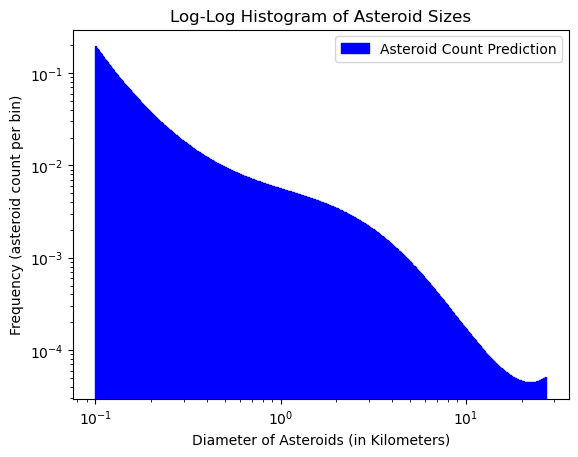

In [3]:
diff_diameter = np.diff(diameter_list)
diameter_list, r_list = diameter_list[:-1], r_list[:-1]

asteroid_count_list = r_list * diff_diameter * (diameter_list ** -3)

plt.bar(diameter_list, asteroid_count_list, width=np.diff(np.append(diameter_list, diameter_list[-1]*1.01)), 
        align='edge', edgecolor='b', color='blue', label='Asteroid Count Prediction')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Diameter of Asteroids (in Kilometers)")
plt.ylabel("Frequency (asteroid count per bin)")
plt.title("Log-Log Histogram of Asteroid Sizes")
plt.legend()
plt.show()

Figure 1. Log-log histogram of the predicted differential asteroid size frequency distribution, showing expected asteroid counts per diameter bin as a function of diameter in kilometers.

## Overview of the simulation workflow

The analysis begins on the impactor side. 
$\log_{10}(R) = a_0 + \sum_{n=1}^{14} a_n \left[ \log_{10}(D) \right]$

The coefficients for this polynomial fit can be found from the same study (2002; Table 1). The continuous SFD is evaluated on a logarithmically spaced diameter grid, converted into expected counts per bin, and then normalized to a probability distribution. We can use this probability distribution to generate a population of asteroids. 

In our modelling, we made two core assumptions. First, we assume that all asteroids are spherical, so that we can easily calculate asteroid volume from asteroid diameter. Then, we assume that all asteroids have a constant density, $\rho_{\text{imp}}= 2.7 \frac{g}{cm^3}$ — an assumption made by Ivanov et al. (2002). Thus, each sampled asteroid is then treated as a sphere with a fixed bulk density. Diameters are converted to volumes using the usual spherical volume formula as outlined in **calculate_volume()**, and then to masses by multiplying by the density (as shown in **calculate_mass**). Independently, we sample impact velocities from a Poisson distribution centered on the mean lunar impact speed of 17 km/s reported by Yue et al. (2013), and convert from kilometers per second to meters per second. Taken together, the mass and velocity samples define a kinetic energy distribution for the impactor population.


We can then convert our size frequency distribution of asteroid sizes to a probability distribution function by normalizing $dN(D)$. We can use this later to generate a population of asteroid frequency based on asteroid diameter. We can verify that this probability distribution function is accurate by summing the values. (Note: due to float precision issues in Python, the sum of the probability distribution will not exactly be 1.) As we can see below, our probability distribution function is now `normalized_asteroid_count_list`.

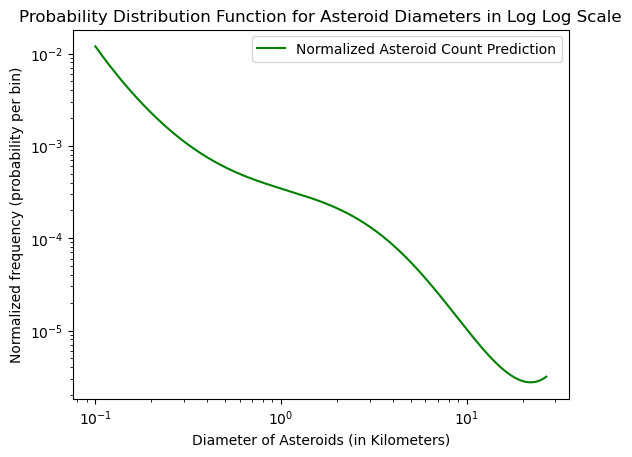

The sum of the probabilty distribution is 0.9999999999999972


In [4]:
normalized_asteroid_count_list = asteroid_count_list / sum(asteroid_count_list)

from matplotlib import pyplot as plt
# plt.bar(diameter_list, normalized_asteroid_count_list, width=np.diff(np.append(diameter_list, diameter_list[-1]*1.01)), 
#         align='edge', edgecolor='k', color='skyblue', alpha=0.01, label='Asteroid Count Prediction')
plt.plot(diameter_list, normalized_asteroid_count_list, label='Normalized Asteroid Count Prediction', color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Diameter of Asteroids (in Kilometers)")
plt.ylabel("Normalized frequency (probability per bin)")
plt.title("Probability Distribution Function for Asteroid Diameters in Log Log Scale")
plt.legend()
plt.show()

print("The sum of the probabilty distribution is", sum(normalized_asteroid_count_list))

Figure 2. Normalized probability distribution function for asteroid diameters, where the area under the curve sums to one and highlights which size ranges dominate the mass budget.

### Characterizing Asteroid Mass and Volume
Since we will need kinetic energy to characterize crater size based on asteroid impact, we will need to determine asteroid mass and volume. In our modelling, we made two core assumptions. The first assumption we made was that all of our asteroids were spherical, which helped us uniformly calculate the volumes of our asteroids. The second assumption came from the Ivanov et al. (2002) study, which made a similar assumption that asteroids have a constant density: $\rho_{\text{imp}}= 2.7 \frac{g}{cm^3}$. Diameters are converted to volumes using the usual spherical volume formula as outlined in **calculate_volume()**, and then to masses by multiplying by the density (as shown in **calculate_mass**). 

For example, we calculate asteroid volume and mass using the sample asteroid list from before:

In [5]:
volume_list = calculate_volume(diameter_list)
mass_list = calculate_mass(volume_list)

### Characterizing Asteroid Velocities and Kinetic Energy
To determine the lunar crater size from asteroid impact, calculating the kinetic energy for impacting asteroids was critical. First, we needed a probability distribution for asteroid velocites. We assumed that the distribution of asteroid velocities would follow a Poisson distribution as each asteroid impact is an independent event occurring within a fixed interval where events occur with a constant expected value. We established the characteristics of our Poisson distribution using a simulated impact velocity distribution of Near-Earth asteroids, where the mean velocity was 17.1 km/s (Yue et al. 2013). 

We created a function `sample_impact_velocities_poisson()`, which takes a mean value (in this case 17.1 km/s) and the number of velocity samples. Using this function, we can generate a sample asteroid velocity distribution (with a sample size of 10000) in m/s below:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


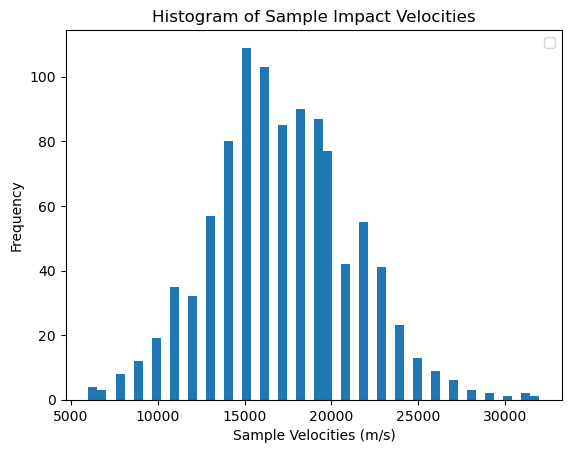

In [6]:
sample_velocities = sample_impact_velocities_poisson(n_samples=len(mass_list), mean_velocity_km_s = 17.1)

plt.figure()
plt.hist(sample_velocities, bins=50)
plt.xlabel("Sample Velocities (m/s)")
plt.ylabel("Frequency")
plt.title("Histogram of Sample Impact Velocities")
plt.legend()
plt.show()

Figure 3. Histogram of Sample Impact Velocities

We can then calculate asteroid kinetic energy from impacting velocities in ergs. We created a kinetic energy function (`calculate_kinetic_energy`) using mass and velocitiies and converted Joules to ergs. 

$KE = \frac{1}{2} m v^2 (10^7)$ 

Below we include a sample kinetic energy distribution. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


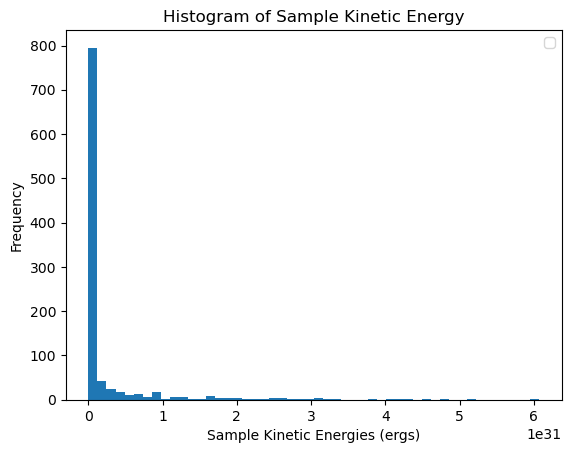

In [7]:
sample_kinetic_energy_ergs = calculate_kinetic_energy(np.asarray(mass_list), np.asarray(sample_velocities))

plt.figure()
plt.hist(sample_kinetic_energy_ergs, bins=50)
plt.xlabel("Sample Kinetic Energies (ergs)")
plt.ylabel("Frequency")
plt.title("Histogram of Sample Kinetic Energy")
plt.legend()
plt.show()


Figure 3. Histogram of Sample Kinetic Energies (ergs)

### Characterizing Lunar Craters using Crater Scaling Laws
To scale lunar craters based on the asteroid kinetic energy and mass, we used known crater scaling laws, outlined by Holsapple (1987):

$ V = 3.02 \,
E^{0.648} \,
m^{0.136} \,
g^{-0.648} \,
\rho_{\text{imp}}^{0.216} \,
\rho_{\text{moon}}^{-1}
$

In this equation, E refers to energy in ergs, m refers to mass in kg, g refers to the moon's gravitational constant, $\rho_{\text{imp}}$ is the asteroid density, and $\rho_{\text{moon}}$ is the moon density. Using the sample mass and energy, we can use this crater scaling law to calculate a sample crater diameter in meters. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


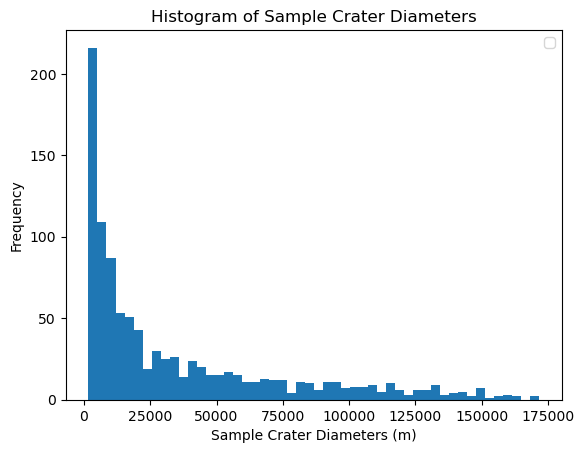

In [8]:
sample_crater_diameters = calculate_crater_diameters_v2(energy_population=sample_kinetic_energy_ergs, mass_population=np.asarray(mass_list)) 
plt.figure()
plt.hist(sample_crater_diameters, bins=50)
plt.xlabel("Sample Crater Diameters (m)")
plt.ylabel("Frequency")
plt.title("Histogram of Sample Crater Diameters")
plt.legend()
plt.show()

Figure 3. Histogram of Sample Crater Diameters (m)

### Monte Carlo Simulations
After establishing the physical relationships between impacting asteroids and lunar craters—through distributions and scaling laws—we use Monte Carlo simulations to generate a synthetic population of lunar craters. The monte_carlo_simulation function constructs a combined population by concatenating the results of multiple runs, where each run generates an N-sized population of asteroids with assigned diameters, computed volumes, and computed masses. Each run samples N asteroids across the 0.1–27 km diameter range.

For this investigation, we simulate 100,000 asteroids per run, and perform 1,000 runs in total, and we plot the concatenated results of multiple runs below. 

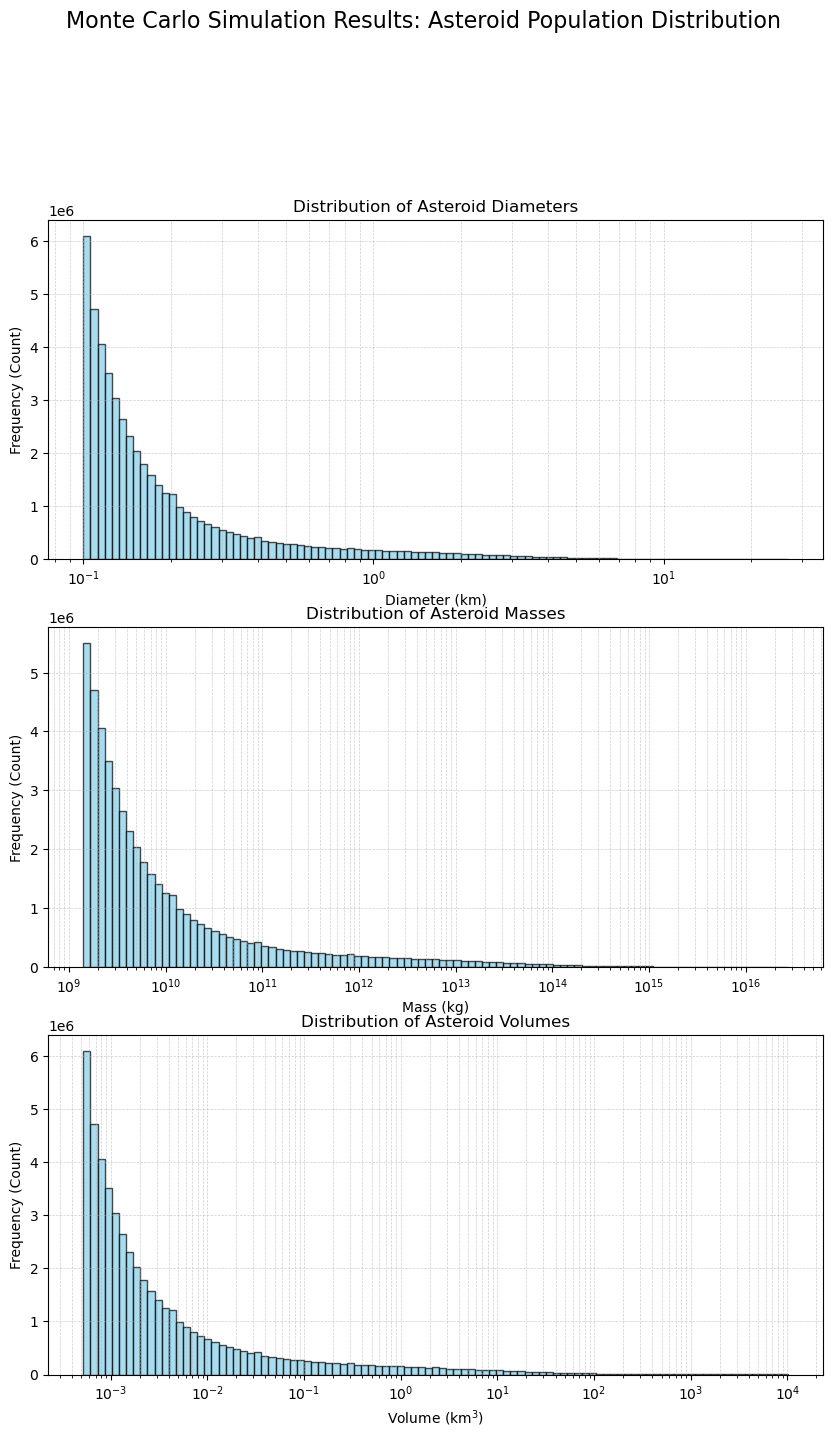

In [9]:
total_mass_list, total_diameter_list, total_volume_list = monte_carlo_simulation(diameter_list, normalized_asteroid_count_list, runs = RUNS, k = POPULATION_SIZE)

total_diameter_list = np.array(total_diameter_list)
total_mass_list = np.array(total_mass_list)
total_volume_list = np.array(total_volume_list)

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plt.suptitle('Monte Carlo Simulation Results: Asteroid Population Distribution', 
             fontsize=16, y=1.02)

create_log_histogram(
    total_diameter_list, 
    'Distribution of Asteroid Diameters', 
    'Diameter (km)', 
    axes[0]
)

# 2. Mass Histogram
create_log_histogram(
    total_mass_list, 
    'Distribution of Asteroid Masses', 
    'Mass (kg)', 
    axes[1]
)

# 3. Volume Histogram
create_log_histogram(
    total_volume_list, 
    'Distribution of Asteroid Volumes', 
    'Volume ($\mathrm{km}^3$)', 
    axes[2]
)

Figure 4. Monte Carlo histograms of sampled asteroid diameters, masses, and volumes for the impactor population used in the crater modeling.

# Results

After using our Monte Carlo simulation to generate an asteroid population, we can now use the physical relationships that we have established to create a simple lunar crater size frequency distributions. After creating the lunar crater SFD, we will compare our results with the Robbins Lunar Crater Database and the Neukem Production function (Robbins 2019; Ivanov et al. 2002). We will use `monte_carlo_crater_population` to use the entire set of simulated asteroid mass populations for 1000 runs and determine crater diameter. Internally, this function uses the sample velocity poisson distribution, energy conversion, and crater scaling functions to generate a resulting set of crater diameters in meters. 

In [10]:
results = monte_carlo_crater_population(
    n_runs=N_MONTE_CARLO,
    mass_population=np.concatenate(total_mass_list, axis=0),
    random_state=42,
)

## Comparing against the Robbins 2019 Lunar Crater database

To compare the Monte Carlo model with real data, we load the Robbins (2019) simple crater catalog and compute a cumulative size frequency distribution \(N(>D)\) for the observed craters. We perform the same cumulative count for the simulated crater diameters produced by the Monte Carlo simulations. Then, we place both curves on the same log log axes. 

The resulting figure with error bars (Figure 5) shows that the simulated simple crater SFD follows the observed Robbins slope over an intermediate diameter range, while diverging at the smallest and largest diameters where our scaling law and sampling assumptions are least reliable. The error bars on the Monte Carlo curve are based on Poisson counting statistics and communicate how much of the difference between the curves can be explained by finite sampling noise. This visual and quantitative comparison is the primary test of whether our chosen impactor SFD, velocity model, and scaling law together reproduce the observed crater record. We normalize both simulated and observed crater size frequency distributions to compare both results. 

In [ ]:
catalog = load_crater_catalog("lunar_crater_database_robbins_2018.csv")
simple_catalog = get_simple_craters(catalog, simple_limit_km=MAX_DIAMETER)

D_obs_m = simple_catalog["D_final_m"].to_numpy()
D_sim_m = results["crater_diameters_m"]
D_obs_sorted_m, N_obs, normalized_N_obs = compute_cumulative_sfd(D_obs_m)
D_sim_sorted_m, N_sim, normalized_N_sim = compute_cumulative_sfd(D_sim_m)
error_sim = np.sqrt(N_sim) / N_sim[0]
plt.figure(figsize=(7, 5))
plt.loglog(
    D_obs_sorted_m / 1000.0,
    normalized_N_obs,
    label="Robbins 2019 simple craters",
    color="black",
)
plt.errorbar(
    D_sim_sorted_m / 1000.0,
    normalized_N_sim,
    yerr=error_sim,
    fmt="--",
    color="tab:orange",
    ecolor="lightblue",
    elinewidth=1,
    capsize=3,
    label="Monte Carlo model (with error bars)",
)

plt.xlabel("Crater diameter D [km]")
plt.ylabel("Cumulative N(>D)")
plt.title("Lunar Simple Crater SFD: Observed vs Monte Carlo")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.show()

Figure 5. Cumulative simple crater size frequency distribution from Robbins (2019) compared with the Monte Carlo model, including Poisson error bars on the simulated cumulative counts.

## Comparing our Monte Carlo Simulation, Robbins Lunar Crater Database, and the Neukum Production Function

In addition to the direct catalog comparison, we use the Neukum Production Function (NPF) as a reference model. Using the coefficients from the Ivanov (2002) study for the NPF, we were able to replicate the normalized NPF crater SFD on the log-log plot as the Robbins and Monte Carlo simulations. 

Overlaying the Neukum curve with the Robbins catalog and Monte Carlo results (Figure 6) lets us see whether our simulation is consistent with the long term crater chronology that underpins lunar surface age estimates. In our runs the Neukum curve tends to lie close to the Robbins data in slope but overestimates creater diameters by orders of ten. 

The final plots overlay three different perspectives on lunar crater statistics. The Robbins catalog provides an empirical size frequency distribution derived from detailed crater counts. The Neukum style chronology curve represents a parametric model for cumulative crater production as a function of diameter that has been calibrated against radiometric ages. Our Monte Carlo results sit between these two: they start from assumptions about the impactor population and scaling laws and then produce a synthetic crater size distribution that can be checked against both the catalog and the chronology curve.

By plotting all three together in the same diameter and cumulative count space, we can see not only whether the Monte Carlo model reproduces the overall slope and normalization of the observed size distribution, but also where it deviates. Agreement in the 0.5 to 50 kilometer range improves our confidence that the adopted impactor size distribution and scaling laws are reasonable. Systematic offsets or curvature signal where the modeling assumptions may need refinement, such as incorporating a broken power law in the asteroid distribution or a transition between simple and complex crater regimes.

In [ ]:
neukum_2001_coefficients = [
    -3.0876,     # a0
    -3.557528,   # a1
    +0.781027,   # a2
    +1.021521,   # a3
    -0.156012,   # a4
    -0.444058,   # a5
    +0.019977,   # a6
    +0.086850,   # a7
    -0.005874,   # a8
    -0.006809,   # a9
    +0.000825,   # a10 (Converted from +8.25 x 10^-4)
    +0.0000554   # a11 (Converted from +5.54 x 10^-5)
]

# create initial lists
bin_count = 1000
min_diameter = 1
max_diameter = MAX_DIAMETER
diameter_list = np.logspace(np.log10(min_diameter), np.log10(max_diameter), num=bin_count )

# get the list of relative plots
neukeum_crater_count_list = r_plot_prediction(diameter_list=diameter_list, coefficient_list=neukum_2001_coefficients)

neukeum_probability_distribution = neukeum_crater_count_list / sum(neukeum_crater_count_list)
crater_population = np.asarray(monte_carlo_crater(diameter_list, neukeum_probability_distribution, runs = RUNS, k = POPULATION_SIZE))
print(list(crater_population))

list_crater_count = [D_obs_m, D_sim_m, crater_population*1000]
labels = ["Robbins 2019 Simple Craters Database (Robbins 2019)", "Projectile-based Monte Carlo Crater Simulation", "Neukum 2001 Model (Ivanov et al. 2001)"]

plot_sfd_overlay_2(list_crater_count,labels, D_min_km=0.01, title="Cumulative SFD Comparison: Robbins 2019 vs Monte Carlo vs Neukum 2001")

Figure 6. Overlay of normalized cumulative crater size frequency distributions from Robbins (2019), the Monte Carlo model, and a Neukum (2001) production function.

## Kinetic energy distribution of impactors

The final set of plots focuses on the energetic side of the simulation. Using the masses and velocities obtained from the Monte Carlo workflow, we compute the kinetic energy of each impactor and display the resulting distribution on log log axes using `create_log_histogram`. A second histogram shows the distribution of crater diameters implied by the same energy population.

These plots (Figure 7) confirm that most of the kinetic energy is carried by a relatively small fraction of the most massive and fastest impactors, while the many small bodies contribute modestly to the total energy budget. The associated crater diameter histogram reflects this bias, with a broad tail toward larger craters even though the underlying size distribution heavily favors small impactors. Interpreting these distributions helps explain why a seemingly steep impactor SFD can still produce a significant population of multi kilometer craters on the Moon.

In [ ]:
#plot kinetic energy
energy_population= calculate_kinetic_energy(mass_population=np.concatenate(total_mass_list, axis=0), velocity_samples=sample_impact_velocities_poisson(n_samples=N_MONTE_CARLO, random_state=42))
plt.figure(figsize=(10, 6))
create_log_histogram(
    energy_population / 1e7,
    'Distribution of Kinetic Energy of Impactors',
    'Kinetic Energy (Joules)',
    plt.gca()
)



crater_diameters = calculate_crater_diameters(energy_population=energy_population)

plt.figure(figsize=(10, 6))
create_log_histogram(
    crater_diameters,
    'Distribution of Crater Diameters',
    'Crater Diameter (m)',
    plt.gca()
)

Figure 7. Log-log histograms of impactor kinetic energy and the resulting crater diameters derived from the same Monte Carlo impactor population.

# Discussion

In this section we describe in detail the workings of our Monte Carlo simulation, showing how each step of that chain influenced our design choices and how it shows up in the notebook outputs.

## Asteroid diameter, volume, and mass

We begin by specifying a distribution of asteroid diameters, rather than masses, because the observational constraints are usually phrased in terms of size frequency distributions. The diameter grid is chosen to cover the range that contributes to simple lunar craters in our catalog. For each diameter value we treat the impactors as spheres, compute a geometric volume using the relation for a sphere, and then multiply by a fixed bulk density that approximates stony asteroids. This sequence lets us map directly from the literature size distribution to a mass for every synthetic asteroid. Conceptually, the volume conversion tells us how much material is present for a given diameter, while the density links that volume to the amount of matter that will deposit kinetic energy in the target.

This explicit diameter to volume to mass pathway is important because later parts of the notebook need to reason about mass dependent quantities such as momentum and kinetic energy. By separating the geometric and material assumptions we can see how a change in density or shape would propagate through the simulation without touching the higher level logic.

## Mass based probability distribution

Once we have a set of masses associated with the diameter bins, we need to decide how often objects from each bin should appear in the Monte Carlo runs. The notebook constructs a probability distribution that is proportional to the expected number of impactors in each size bin, which is itself derived from the chosen size frequency distribution. In practice this means computing a relative rate or weight for each diameter interval and normalizing the resulting array so that the weights sum to one.

When we sample impactors we generate indices from this discrete distribution so that small bodies, which are far more numerous, dominate the synthetic population, while rare large bodies still appear with the appropriate low probability. Designing the simulation this way enforces consistency between the theoretical size distribution and the empirical histogram of masses that emerges from the runs. It also makes clear that the randomness lives in the sampling step, not in the definition of the underlying mass spectrum.

## Velocity distribution

The velocity distribution is specified separately from the size distribution using a mean impact speed motivated by dynamical studies of lunar impactors. Rather than assigning a single characteristic velocity, the functions generate random velocities for each impact so that the model explores a range of energies. Depending on the exact implementation this may involve sampling from a normal, log normal, or other simple distribution centered on the literature value.

Splitting size and velocity in this way matches the physical picture in which orbital dynamics set typical encounter speeds while the collisional history of the asteroid belt sets the size spectrum. It also lets us examine how sensitive the crater size distribution is to the width of the velocity distribution without needing to rederive the size distribution itself.

## Monte Carlo simulation results

With size, mass, and velocity distributions in hand, the core Monte Carlo loop repeatedly generates impactors, converts their properties into transient crater diameters using the chosen scaling law, and stores the resulting diameters. The notebook then accumulates these results into cumulative size frequency distributions that can be compared with observations. Because we use many runs and a large population per run, the simulation averages over the random sampling noise and highlights systematic mismatches between the model and the data.

An important design choice here is to keep track of intermediate quantities such as total mass delivered and total excavated volume. These diagnostics help us interpret whether discrepancies arise from the normalization of the impact flux or from the physics embedded in the scaling law. For example, if the model overproduces large craters while matching the small crater counts, that points toward issues in the diameter exponent rather than in the overall flux level.


# Conclusion

Our main goal in this project was to test whether a simple, physically motivated impactor population could reproduce the observed size frequency distribution of lunar simple craters that underpins modern crater chronometry. Starting from an assumed asteroid SFD, a fixed bulk density, and a velocity distribution anchored in earlier work on lunar impacts, we used gravity dominated scaling relations to turn impact energies into crater diameters and then compared the resulting synthetic crater record with the Robbins (2019) catalog and a Neukum Production Function (Ivanov et al. 2002).

Within the diameter range where our scaling law is appropriate, the Monte Carlo model recovers a cumulative crater slope that is for the most part consistent with both Robbins and Neukum. As shown in Figure 6, our simulated curve follows the observed SFD over an most diameters, only departing at the smallest and largest sizes where unknwons such as transitions between simple and complex craters and  complex scaling parameters become important. In this sense, our work supports the notion that a steeply falling impactor SFD combined with gravity dominated scaling is sufficient to explain the observed abundance of kilometer scale lunar craters.

At the same time, our results are not entirely accurate. The simplifications we made regarding a single impactor density, a simple velocity model, and a single set of scaling parameters ignore material differences between projectiles and target terrains and neglect time variation in the impact flux. These simplifications, while necessary to run our model in a reasonable amount of time, inherently limit our ability to use the model to distinguish among detailed hypotheses for the Moon's bombardment history.

Future work could relax these assumptions by introducing separate SFDs for different populations, using more realistic velocity distributions from orbital integrations, and incorporating scaling laws that account for transitions between simple and complex craters. Extending the comparison beyond the moon and to crater records on Mars or Mercury would also test how universal our chosen impactor model really is. Even in its current form, however, the notebook demonstrates how coupling an asteroid SFD to crater scaling via Monte Carlo techniques can bridge the gap between small body populations and the long term geologic evolution of the Moon's surface.

# Reflections

Building this notebook forced us to translate verbal descriptions of crater scaling laws and impactor populations found within the papers that we converted into explicit, testable code. As such, we had to make a series of modeling decisions, from the scaling laws we wanted to implement, to how finely to sample the robbins database & how many Monte Carlo trials to run. Each of these seemingly small decisions in reality had huge impacts on the robustness of our model, as we unfortunately don't have the resources nor time to build and run an extremely complex simulation.

The simplifcations we made in terms of the scaling laws made it easier to create explicit functions for calculating diameter, volume, and mass, which in turn ended up making the debugging process much smoother. The decision we made to extensively comment and document our code was also a crucial step in helping to prevent silent errors.

Overall, the exercise highlighted how much uncertainty remains even when the code runs without errors and produces smooth curves. The apparent agreement between model and data can hide compensating errors in different parts of the pipeline, and small changes in parameters can move the curves by factors that matter for geological interpretation. Documenting our thought process in markdown alongside the code is one way to make those choices visible to future readers, including ourselves, and to invite more careful scrutiny of both the physics and the implementation.


# References
Cross, C. A. 1966, Monthly Notices of the Royal Astronomical Society, 134 (OUP), 245

Hartmann, W. K. 1999, Meteoritics and Planetary Science, 34 (Wiley), 167

Holsapple, K. A. 1987, International Journal of Impact Engineering, 5, 343

Ivanov, B. A., Neukum, G., Bottke, W. F., Jr., & Hartmann, W. K. 2002, in Asteroids III, 89, https://ui.adsabs.harvard.edu/abs/2002aste.book...89I

Robbins, S. J. 2019, Journal of Geophysical Research: Planets, 124, 871

Schmidt, R. M. 1980, Lunar and Planetary Science Conference Proceedings, 3, 2099

Wheeler, L. F., & Mathias, D. L. 2019, Icarus, 327, 83

Wilhelms, D. E., Oberbeck, V. R., & Aggarwal, H. R. 1978, Lunar and Planetary Science Conference Proceedings, 3, 3735

Williams, J.-P., Pathare, A. V., & Aharonson, O. 2014, Icarus, 235 (Elsevier), 23

Yue, Z., Johnson, B., Minton, D., et al. 2013, Nature Geoscience, 6, 435

In [ ]:
import numpy as np
from random import choices
from matplotlib import pyplot as plt
import pandas as pd
import math

RUNS = 500
POPULATION_SIZE = 100000

# -----CONSTANTS------
MU_REGOLITH = 0.41  # μ from Holsapple paper's value for lunar regolith (dimensionless)
RHO_IMP_G_CM3 = 2.7  # impactor density [g/cm^3]
RHO_IMP_KG_M3 = (
    RHO_IMP_G_CM3 * 1000.0
)  # converted to kg/m^3 (2.7 g/cm^3 -> 2700 kg/m^3)
MEAN_IMPACT_VEL_KM_S = 17.0  # Mean impact velocity [km/s] (From Yue et al. (2013))
MEAN_IMPACT_VEL_M_S = MEAN_IMPACT_VEL_KM_S * 1000.0  # [m/s]
N_MONTE_CARLO = RUNS * POPULATION_SIZE  # monte carlo run number (count)
VEL_EXPONENT = 0.44  # exponent used for velocity scaling (dimensionless)
CRATER_TO_PROJECTILE_RATIO = (
    10.0  # crater diameter / projectile diameter (dimensionless)
)
MAX_DIAMETER = 300  # maximum crater diameter filter [km] — note: earlier comment mentioned 300 km which is inconsistent with this value


def r_plot_prediction(diameter_list, coefficient_list):
    # expects a list of diameters in km and outputs coefficient ount
    asteroid_count_list = []
    for d in diameter_list:
        log_d = np.log10(d)
        log_n = 0
        for i, coeff in enumerate(coefficient_list):
            log_n += coeff * (log_d**i)
        n = 10**log_n
        asteroid_count_list.append(n)
    return asteroid_count_list


def generate_asteroid_population(diameter_list, normalized_asteroid_list, k=100):
    new_population = choices(diameter_list, weights=normalized_asteroid_list, k=k)
    return new_population


def calculate_volume(simulated_asteroid_diameters_list):
    # Input: simulated_asteroid_diameters_list elements are diameters in [km]
    # Output: list of volumes in [km^3] computed assuming spherical asteroids
    volume_list = []
    for d in simulated_asteroid_diameters_list:
        r = d / 2
        volume = (4 / 3) * np.pi * (r**3)
        volume_list.append(volume)
    return volume_list


def calculate_mass(volume_list):
    # Assumes input volume_list elements are in [km^3].
    # density is intended to be the impactor density in [kg/km^3].
    # NOTE: If RHO_IMP_G_CM3 = 2.7 g/cm^3 -> 2700 kg/m^3 -> 2700 * 1e9 = 2.7e12 kg/km^3.
    # The value 2.7e9 here is likely incorrect relative to RHO_IMP_G_CM3; check unit conversion.
    density = 2.7e12  # kg/km^3  (EXPECTED ~2.7e12 kg/km^3 if using 2.7 g/cm^3)
    mass_list = []
    for volume in volume_list:
        # mass in [kg] if density is [kg/km^3] and volume is [km^3]
        mass = density * volume
        mass_list.append(mass)
    return mass_list


def monte_carlo_neukem(diameter_list, normalized_asteroid_count_list, runs=1000, k=100):
    # Returns a list (length = runs) of lists of selected diameters.
    # The diameters in the returned lists have the same units as `diameter_list` (expected [km]).
    crater_diameter_list = []
    for _ in range(runs):
        # get average volume, and diameters
        simulated_asteroid_diameters_list = generate_asteroid_population(
            diameter_list, normalized_asteroid_count_list, k
        )
        crater_diameter_list.append(simulated_asteroid_diameters_list)

    return crater_diameter_list


def monte_carlo_simulation(
    diameter_list, normalized_asteroid_count_list, runs=1000, k=100
):
    # Returns:
    #   total_mass_list : list of lists of masses [kg] (if calculate_mass's density units are correct)
    #   total_diameter_list : list of lists of diameters [km] (same units as diameter_list)
    #   total_volume_list : list of lists of volumes [km^3]
    total_mass_list = []
    total_diameter_list = []
    total_volume_list = []
    for _ in range(runs):
        # get average volume, and diameters
        simulated_asteroid_diameters_list = generate_asteroid_population(
            diameter_list, normalized_asteroid_count_list, k
        )
        volume_list = calculate_volume(simulated_asteroid_diameters_list)
        mass_list = calculate_mass(volume_list)

        total_mass_list.append(mass_list)
        total_diameter_list.append(simulated_asteroid_diameters_list)
        total_volume_list.append(volume_list)

    return total_mass_list, total_diameter_list, total_volume_list


def create_log_histogram(data, title, xlabel, ax):
    # Filter for positive values, as log scale cannot handle non-positives
    data_positive = data[data > 0]

    if len(data_positive) == 0:
        ax.set_title(title)
        ax.text(
            0.5, 0.5, "No positive data to plot.", transform=ax.transAxes, ha="center"
        )
        return

    # Determine the range in log space
    min_val = data_positive.min()
    max_val = data_positive.max()

    # Create logarithmically spaced bins (100 bins for resolution)
    bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)

    # Plot the histogram
    # Density=False plots the raw count (frequency)
    ax.hist(data_positive, bins=bins, color="skyblue", edgecolor="black", alpha=0.7)

    # Set log scale for x-axis
    ax.set_xscale("log")

    # Set labels and title
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Frequency (Count)")
    ax.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.6)


# ------ FUNCTIONS ----------
def load_crater_catalog(csv_path: str) -> pd.DataFrame:
    """
    Get the whole database's worth of crater diameters.
    Notes on units:
      - DIAM_CIRC_IMG is assumed to be in [km] (this code treats it as km).
      - D_final_m is created in [m] (km * 1000).
    """
    df = pd.read_csv(csv_path)
    df = df.copy()

    # filter craters less than MAX_DIAMETER km (DEFAULT = 35 km)
    # NOTE: previous comment said "300 kilometers" which is inconsistent with MAX_DIAMETER = 35
    df = df[df["DIAM_CIRC_IMG"] < MAX_DIAMETER]

    df["D_final_m"] = df["DIAM_CIRC_IMG"] * 1000.0  # convert [km] -> [m]
    return df


def get_simple_craters(df: pd.DataFrame, simple_limit_km: float = 100) -> pd.DataFrame:
    """
    Filter the crater database down to simple craters.
    Note:
      - The docstring says "10 km or less", but the default parameter is 10000.
      - This is likely a bug: a sensible default for `simple_limit_km` would be 10.0 (km).
    Args:
      df: DataFrame with DIAM_CIRC_IMG in [km].
      simple_limit_km: threshold in [km] (default currently 10000 — check intended value).
    """
    mask = df["DIAM_CIRC_IMG"] <= simple_limit_km
    return df[mask].copy()


def sample_impact_velocities_poisson(
    n_samples: int,
    mean_velocity_km_s: float = MEAN_IMPACT_VEL_KM_S,
    random_state: int | None = None,
):
    """
    Sample impact velocities from a Poisson distribution with mean
    `mean_velocity_km_s` (in km/s), then convert to m/s.
    Returns:
      velocity array in [m/s]
    """
    rng = np.random.default_rng(random_state)
    v_km_s = rng.poisson(lam=mean_velocity_km_s, size=n_samples).astype(float)
    # avoid zero velocities from Poisson draw
    v_km_s[v_km_s == 0] = 1e-3
    return v_km_s * 1000  # [m/s]


def calculate_kinetic_energy(mass_population: np.ndarray, velocity_samples: np.ndarray):
    """
    Calculate kinetic energy for each mass and velocity combination.
    KE (Joules) = 0.5 * m[kg] * v[m/s]^2
    This function multiplies by 1e7 to convert Joules -> ergs:
      1 J = 1e7 erg
    Returns:
      KE_array_ergs : energy in [erg]
    Note: Ensure mass_population is in [kg] and velocity_samples in [m/s] before calling.
    """

    KE_array = 0.5 * mass_population * (velocity_samples**2)
    KE_array_ergs = KE_array * (1e7)
    return KE_array_ergs


def calculate_crater_diameters(energy_population: np.ndarray):
    """
    Convert an energy population into crater diameters.
    Notes on units/assumptions:
      - `energy_population` is expected to be in units compatible with the empirical constant K.
        In the code below, K and the "/100" conversion imply V_array is computed in [cm^3],
        so energy_population is likely expected in [erg] (check original source).
      - V_array is treated as a volume in [cm^3]; the cubic root yields a length in [cm],
        and dividing by 100 converts [cm] -> [m], so D_array is returned in [m].
    Returns:
      D_array : crater diameters in [m]
    """
    K = 0.00319
    alpha = 0.726
    V_array = K * (energy_population ** (alpha))
    D_array = (2 * np.cbrt(((3 * V_array) / (4 * math.pi)))) / 100  # convert cm -> m
    print(D_array.flatten())
    return D_array


def calculate_crater_diameters_v2(
    energy_population: np.ndarray, mass_population: np.ndarray
):
    """
    Empirical conversion from energy (and mass) to crater diameter.
    Units and important notes:
      - energy_population is expected to be in [erg] (consistent with calculate_kinetic_energy).
      - mass_population: check units. The exponent on mass (0.136) and the use of densities
        in [g/cm^3] suggests the original formula may have expected mass in [g], not [kg].
        Passing masses in [kg] without converting to [g] will change results.
      - g is set to 162 with a comment 'm/s^2' but lunar surface gravity is ~1.62 m/s^2.
        162 may come from using cm/s^2 (1.62 m/s^2 = 162 cm/s^2). Confirm the intended units.
      - moon_density and impactor_density are in [g/cm^3].
      - The formula produces V_array in [cm^3] (based on later division by 100 to get m),
        so D_array returned below is in [m].
    Returns:
      D_array : crater diameters in [m]
    """
    g = 162  # NOTE: value likely in [cm/s^2] (162 cm/s^2 = 1.62 m/s^2)
    moon_density = 3.344  # g/cm^3
    impactor_density = 2.7  # g/cm^3

    V_array = (
        3.02
        * (energy_population**0.648)
        * (mass_population**0.136)
        * (g**-0.648)
        * (impactor_density**0.216)
        * (moon_density**-1)
    )  # Energy measured in ergs, and mass measured in KG
    D_array = (2 * np.cbrt(((3 * V_array) / (4 * math.pi)))) / 100  # convert cm -> m
    return D_array


def monte_carlo_crater_population(
    n_runs: int, mass_population: np.ndarray, random_state: int | None = None
):
    """
    Monte Carlo pipeline:

    1. Estimate projectile masses from the observed simple crater diameters,
       assuming a fixed crater-to-projectile ratio and spherical impactors.
    2. Calibrate the scaling law on a representative crater size.
    3. Sample masses from the mass population and velocities from a
       Poisson distribution.
    4. Convert (m, v) into crater diameters using the scaling law.
    """

    # Monte Carlo sampling
    velocity_samples = sample_impact_velocities_poisson(
        n_samples=n_runs,
        random_state=random_state,
    )

    kinetic_energy_ergs = calculate_kinetic_energy(
        mass_population=mass_population, velocity_samples=velocity_samples
    )
    D_sim_m = calculate_crater_diameters_v2(
        energy_population=kinetic_energy_ergs,
        mass_population=np.asarray(mass_population),
    )

    # Returned dictionary units:
    #   mass_samples_kg    -> list of masses as provided (expected [kg], but check upstream)
    #   velocity_samples_m_s -> velocities in [m/s]
    #   crater_diameters_m  -> simulated crater diameters in [m]
    return {
        "mass_samples_kg": mass_population,
        "velocity_samples_m_s": velocity_samples,
        "crater_diameters_m": D_sim_m,
    }


def compute_cumulative_sfd(D_m: np.ndarray):
    """
    Compute a cumulative size–frequency distribution N(>D) from
    an array of crater diameters D_m [m].

    Returns:
        D_sorted_m : diameters sorted ascending
        N_gt       : cumulative counts N(>D) for each D_sorted_m
    """
    D_sorted = np.sort(np.asarray(D_m, dtype=float))
    N = np.arange(D_sorted.size, 0, -1)  # N, N-1, ..., 1
    N_total = D_sorted.size

    # N = N_total, N_total-1, ..., 1 (Cumulative counts N(>=D))
    N_gt = np.arange(N_total, 0, -1)

    # F = N / N_total (Normalized cumulative frequency F(>=D))
    F_gt = N_gt / N_total
    return D_sorted, N_gt, F_gt


def plot_sfd_overlay(
    D_obs_m: np.ndarray,
    D_sim_m: np.ndarray,
    title: str = "Lunar Simple Crater SFD: Observed vs Monte Carlo",
):
    """
    Plot cumulative SFDs for observed and simulated craters on a log plot.
    """
    D_obs_sorted_m, N_obs, normalized_N_obs = compute_cumulative_sfd(D_obs_m)
    D_sim_sorted_m, N_sim, normalized_N_sim = compute_cumulative_sfd(D_sim_m)

    # Convert to km for plotting
    D_obs_km = D_obs_sorted_m / 1000.0
    D_sim_km = D_sim_sorted_m / 1000.0

    plt.figure(figsize=(7, 5))
    plt.loglog(D_obs_km, normalized_N_obs, label="Robbins 2019 simple craters")
    plt.loglog(D_sim_km, normalized_N_sim, label="Monte Carlo model", linestyle="--")

    plt.xlabel("Crater diameter D [km]")
    plt.ylabel("Cumulative N(>D)")
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle=":")
    plt.tight_layout()
    plt.show()


def plot_sfd_overlay_v2(
    D_datasets: list[np.ndarray],
    labels: list[str],
    D_min_km: float = 1.0,
    title: str = "Cumulative SFD Comparison",
):
    """
    Plot cumulative SFDs for multiple observed and simulated crater datasets
    on a log plot, normalized to the population with D >= D_min_km.

    Args:
        D_datasets (list[np.ndarray]): A list of 1D arrays, where each array
                                        contains crater diameters (in meters)
                                        for one population.
        labels (list[str]): A list of string labels corresponding to each dataset.
        D_min_km (float): The minimum diameter (in km) to include for
                          normalization and comparison. Defaults to 1.0 km.
    """
    if len(D_datasets) != len(labels):
        raise ValueError("The number of datasets must match the number of labels.")

    D_min_m = D_min_km * 1000.0

    plt.figure(figsize=(8, 6))

    D_max_m = MAX_DIAMETER  # 20 km in meters

    # Define a set of line styles/colors for differentiation
    line_styles = ["-", "--", ":", "-."]

    for i, D_m in enumerate(D_datasets):

        # 1. Filter the data to the comparison window (D >= D_min_m)
        D_filtered = D_m[D_m >= D_min_m]

        # 2. Get sorted diameters and normalized frequencies F'(>=D)
        # We need a function similar to the 'compute_comparison_sfd' discussed earlier.
        # For simplicity here, we'll implement the comparison logic directly.
        D_sorted = np.sort(D_filtered)
        N_total_filtered = D_sorted.size

        if N_total_filtered == 0:
            print(
                f"Warning: Dataset '{labels[i]}' has no craters >= {D_min_km} km. Skipping."
            )
            continue

        # Cumulative frequency calculation F'(>=D)
        N_gt = np.arange(N_total_filtered, 0, -1)
        normalized_N_fraction = N_gt / N_total_filtered

        # Convert to km for plotting
        D_km = D_sorted / 1000.0

        # Plotting the normalized cumulative frequency
        plt.loglog(
            D_km,
            normalized_N_fraction,
            label=labels[i],
            linestyle=line_styles[i % len(line_styles)],  # Cycle through line styles
            linewidth=2,
        )

    # 1. FIXED Y-AXIS  (No LaTeX)
    plt.ylabel("Normalized Cumulative Frequency F'(>= D)")

    # 2. FIXED X-AXIS LABEL (No LaTeX, using f-string for D_min_km)
    plt.xlabel(
        f"Crater diameter D [km] (Comparison range: >= {D_min_km} km & <= {MAX_DIAMETER} km)"
    )

    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", linestyle=":")

    # This should now execute without the Matplotlib ParseFatalException
    plt.tight_layout()
    plt.show()
